In [19]:
import sys
from pathlib import Path
import numpy as np
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
import time

# Agregar src al path
src_path = Path().absolute().parent
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from ppoAgent.utils import set_seed
from ppoAgent.actorCritic import ActorCritic
from ppoAgent.ppo import PPO
from ppoAgent.memory import RolloutBuffer


In [20]:
class RunningNorm:
    def __init__(self, shape, eps=1e-8):
        self.mean = np.zeros(shape, dtype=np.float64)
        self.var = np.ones(shape, dtype=np.float64)
        self.count = eps

    def update(self, x):
        x = np.array(x, dtype=np.float64)
        batch_mean = x.mean(axis=0)
        batch_var = x.var(axis=0)
        batch_count = 1
        delta = batch_mean - self.mean
        tot = self.count + batch_count
        new_mean = self.mean + delta * batch_count / tot
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + delta ** 2 * self.count * batch_count / tot
        self.mean, self.var, self.count = new_mean, M2 / tot, tot

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)
    
    def reset(self):
        self.mean = np.zeros_like(self.mean)
        self.var = np.ones_like(self.var)
        self.count = 1e-8


## Función de Entrenamiento Configurable


In [21]:
def train_cartpole_config(
    config_name,
    learning_rate=3e-4,
    entropy_coef=0.01,
    n_epochs=10,
    use_normalization=True,
    use_agent_api=True,
    n_steps=2048,
    batch_size=64,
    total_updates=50,
    hidden_size=64,
    seed=42,
    verbose=True
):
    """
    Entrena PPO en CartPole con configuración personalizada.
    
    Args:
        config_name: nombre de la configuración
        learning_rate: learning rate
        entropy_coef: coeficiente de entropía
        n_epochs: número de épocas por update
        use_normalization: si usar normalización de observaciones
        use_agent_api: si usar agent.get_action() en lugar de model.get_action_and_value()
        n_steps: pasos por rollout
        batch_size: tamaño de batch
        total_updates: número total de updates
        hidden_size: tamaño de capa oculta
        seed: semilla
        verbose: si imprimir progreso
    
    Returns:
        dict con resultados: rewards_per_update, episode_rewards, metrics_history
    """
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"CONFIGURACIÓN: {config_name}")
        print(f"{'='*60}")
        print(f"Learning Rate: {learning_rate}")
        print(f"Entropy Coef: {entropy_coef}")
        print(f"N Epochs: {n_epochs}")
        print(f"Normalization: {use_normalization}")
        print(f"Agent API: {use_agent_api}")
        print(f"Hidden Size: {hidden_size}")
        print(f"{'='*60}\n")
    
    set_seed(seed)
    device = torch.device("cpu")
    
    # Crear entorno
    env = gym.make("CartPole-v1")
    obs_shape = env.observation_space.shape
    action_dim = env.action_space.n
    
    # Normalizador
    obs_norm = RunningNorm(obs_shape) if use_normalization else None
    
    # Crear modelo y agente
    model = ActorCritic(
        obs_shape, 
        action_dim, 
        action_type="discrete",
        hidden_size=hidden_size
    ).to(device)
    
    agent = PPO(
        actor_critic=model,
        learning_rate=learning_rate,
        clip_epsilon=0.2,
        value_loss_coef=0.5,
        entropy_coef=entropy_coef,
        max_grad_norm=0.5,
        lr_decay=True,
        device=device,
    )
    
    # Buffer
    buffer = RolloutBuffer(
        buffer_size=n_steps,
        obs_shape=obs_shape,
        action_dim=1,
        device=device
    )
    
    # Variables de tracking
    obs, _ = env.reset(seed=seed)
    if use_normalization:
        obs_norm.update(obs)
        obs = obs_norm.normalize(obs)
    
    episode_rewards = []
    episode_lengths = []
    rewards_per_update = []
    metrics_history = []
    
    current_return, current_len = 0, 0
    total_timesteps = 0
    SUCCESS_THRESHOLD = 475
    
    start_time = time.time()
    
    for update in range(1, total_updates + 1):
        for step in range(n_steps):
            # Obtener acción
            if use_agent_api:
                # Usar API del agente (recomendado)
                action, log_prob, value = agent.get_action(obs)
                action_tensor = torch.tensor([action], dtype=torch.long, device=device)
                log_prob_tensor = torch.tensor([log_prob], dtype=torch.float32, device=device)
                value_tensor = torch.tensor([value], dtype=torch.float32, device=device)
            else:
                # Usar API del modelo directamente (original)
                with torch.no_grad():
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                    action_tensor, log_prob_tensor, entropy, value_tensor = model.get_action_and_value(obs_tensor)
                action = action_tensor.item()
            
            # Ejecutar acción
            next_obs, reward, terminated, truncated, info = env.step(action if use_agent_api else action_tensor.item())
            done = terminated or truncated
            
            # Agregar al buffer
            obs_buffer = torch.as_tensor(obs, dtype=torch.float32, device=device)
            buffer.add(
                obs=obs_buffer,
                action=action_tensor if not use_agent_api else torch.tensor([action], dtype=torch.long, device=device),
                log_prob=log_prob_tensor,
                reward=torch.tensor([reward], dtype=torch.float32, device=device),
                done=torch.tensor([done], dtype=torch.float32, device=device),
                value=value_tensor
            )
            
            current_return += reward
            current_len += 1
            
            obs = next_obs
            if use_normalization:
                obs_norm.update(obs)
                obs = obs_norm.normalize(obs)
            
            if done:
                episode_rewards.append(current_return)
                episode_lengths.append(current_len)
                current_return, current_len = 0, 0
                obs, _ = env.reset()
                if use_normalization:
                    obs_norm.update(obs)
                    obs = obs_norm.normalize(obs)
        
        # Bootstrap
        with torch.no_grad():
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            if use_agent_api:
                _, _, last_v = agent.get_action(obs)
                last_value = last_v
            else:
                _, _, _, last_v = model.get_action_and_value(obs_tensor)
                last_value = last_v.item()
        
        buffer.compute_returns_and_advantage(
            last_value=last_value,
            last_done=done,
            gamma=0.99,
            gae_lambda=0.95
        )
        
        total_timesteps += n_steps
        
        # Update
        metrics = agent.update(
            rollout_buffer=buffer,
            batch_size=batch_size,
            n_epochs=n_epochs,
            total_timesteps=total_updates * n_steps,
            current_timestep=total_timesteps
        )
        
        metrics_history.append(metrics)
        buffer.reset()
        
        # Calcular promedio
        avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards) if episode_rewards else 0
        rewards_per_update.append(avg_reward)
        
        if verbose and update % 5 == 0:
            recent_rewards = episode_rewards[-10:] if len(episode_rewards) >= 10 else episode_rewards
            std_reward = np.std(recent_rewards) if len(recent_rewards) > 1 else 0.0
            solved_marker = " ✓" if avg_reward >= SUCCESS_THRESHOLD else ""
            print(f"Update {update:03d}/{total_updates} | AvgR: {avg_reward:6.1f} ± {std_reward:5.2f}{solved_marker} | "
                  f"PolLoss: {metrics['policy_loss']:.4f} | Ent: {-metrics['entropy_loss']:.4f}")
        
        # NO hacer early stopping - continuar con todos los updates para ver estabilidad
    
    elapsed = time.time() - start_time
    
    results = {
        'config_name': config_name,
        'rewards_per_update': rewards_per_update,
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'metrics_history': metrics_history,
        'total_timesteps': total_timesteps,
        'elapsed_time': elapsed,
        'final_avg_reward': rewards_per_update[-1] if rewards_per_update else 0,
        'solved': rewards_per_update[-1] >= SUCCESS_THRESHOLD if rewards_per_update else False
    }
    
    env.close()
    
    return results


In [22]:
# ============================================================================
# CONFIGURACIÓN GLOBAL
# ============================================================================
# Ajusta este valor para cambiar el número de updates en todas las configuraciones
TOTAL_UPDATES = 150  # Aumentado de 50 para dar más tiempo de convergencia

# ============================================================================
# CONFIGURACIONES A PROBAR (Solo 3 para claridad)
# ============================================================================
configs = [
    {
        'name': '1. Original (Baseline)',
        'learning_rate': 3e-4,
        'entropy_coef': 0.01,
        'n_epochs': 10,
        'use_normalization': True,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': '2. Sin Normalización (La que funcionó)',
        'learning_rate': 3e-4,
        'entropy_coef': 0.01,
        'n_epochs': 10,
        'use_normalization': False,  # Esta fue la que llegó a 500
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': '3. Sin Normalización + Mejores Parámetros',
        'learning_rate': 2.5e-4,  # LR más conservador
        'entropy_coef': 0.1,  # Mayor exploración
        'n_epochs': 4,  # Menos épocas para evitar overfitting
        'use_normalization': False,  # Sin normalización (como la que funcionó)
        'use_agent_api': True,  # Usar API correcta
        'hidden_size': 64
    }
]

print(f"Total de configuraciones: {len(configs)}")
print(f"Updates por configuración: {TOTAL_UPDATES}")
print(f"Tiempo estimado: ~{len(configs) * TOTAL_UPDATES * 0.5 / 60:.1f} minutos (aproximado)")


Total de configuraciones: 3
Updates por configuración: 150
Tiempo estimado: ~3.8 minutos (aproximado)


## Ejecutar Entrenamientos


In [23]:
# Ejecutar todas las configuraciones
all_results = []

print(f"\n{'='*80}")
print(f"INICIANDO PRUEBA DE {len(configs)} CONFIGURACIONES")
print(f"Updates por configuración: {TOTAL_UPDATES}")
print(f"{'='*80}\n")

start_total = time.time()

for i, config in enumerate(configs, 1):
    print(f"\n{'#'*80}")
    print(f"[{i}/{len(configs)}] Probando: {config['name']}")
    print(f"{'#'*80}")
    
    result = train_cartpole_config(
        config_name=config['name'],
        learning_rate=config['learning_rate'],
        entropy_coef=config['entropy_coef'],
        n_epochs=config['n_epochs'],
        use_normalization=config['use_normalization'],
        use_agent_api=config['use_agent_api'],
        hidden_size=config['hidden_size'],
        total_updates=TOTAL_UPDATES,  # Usar el valor global
        verbose=True
    )
    
    all_results.append(result)
    
    print(f"\n✓ Completado: {config['name']}")
    print(f"  Final Avg Reward: {result['final_avg_reward']:.2f}")
    print(f"  Max Reward: {max(result['episode_rewards']) if result['episode_rewards'] else 0:.2f}")
    print(f"  Solved: {'✓ SÍ' if result['solved'] else '✗ NO'}")
    print(f"  Time: {result['elapsed_time']:.1f}s")
    print(f"  Timesteps: {result['total_timesteps']:,}")

elapsed_total = time.time() - start_total
print(f"\n{'='*80}")
print(f"TODAS LAS CONFIGURACIONES COMPLETADAS")
print(f"Tiempo total: {elapsed_total/60:.1f} minutos")
print(f"{'='*80}")



INICIANDO PRUEBA DE 3 CONFIGURACIONES
Updates por configuración: 150


################################################################################
[1/3] Probando: 1. Original (Baseline)
################################################################################

CONFIGURACIÓN: 1. Original (Baseline)
Learning Rate: 0.0003
Entropy Coef: 0.01
N Epochs: 10
Normalization: True
Agent API: False
Hidden Size: 64

✓ Random seed set to 42
Update 005/150 | AvgR:   62.6 ± 31.58 | PolLoss: -0.0119 | Ent: 0.6180
Update 010/150 | AvgR:  102.9 ± 55.77 | PolLoss: -0.0112 | Ent: 0.6004
Update 015/150 | AvgR:  178.2 ± 114.76 | PolLoss: -0.0052 | Ent: 0.5842
Update 020/150 | AvgR:  155.5 ± 30.20 | PolLoss: -0.0049 | Ent: 0.5894
Update 025/150 | AvgR:  228.1 ± 84.51 | PolLoss: -0.0048 | Ent: 0.5918
Update 030/150 | AvgR:  191.8 ± 59.40 | PolLoss: -0.0022 | Ent: 0.5940
Update 035/150 | AvgR:  217.0 ± 95.47 | PolLoss: -0.0029 | Ent: 0.5975
Update 040/150 | AvgR:  173.5 ± 31.26 | PolLoss: -0.0029 |

## Comparar Resultados


In [24]:
# Crear tabla comparativa
import pandas as pd

comparison_data = []
for result in all_results:
    comparison_data.append({
        'Configuración': result['config_name'],
        'Final Avg Reward': f"{result['final_avg_reward']:.2f}",
        'Max Reward': f"{max(result['episode_rewards']) if result['episode_rewards'] else 0:.2f}",
        'Solved': '✓' if result['solved'] else '✗',
        'Timesteps': result['total_timesteps'],
        'Time (s)': f"{result['elapsed_time']:.1f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACIÓN DE CONFIGURACIONES")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)



COMPARACIÓN DE CONFIGURACIONES
                            Configuración Final Avg Reward Max Reward Solved  Timesteps Time (s)
                   1. Original (Baseline)           288.50     500.00      ✗     307200    110.8
   2. Sin Normalización (La que funcionó)           411.50     500.00      ✗     307200    102.2
3. Sin Normalización + Mejores Parámetros           360.00     500.00      ✗     307200     76.9


## Visualizar Curvas de Aprendizaje


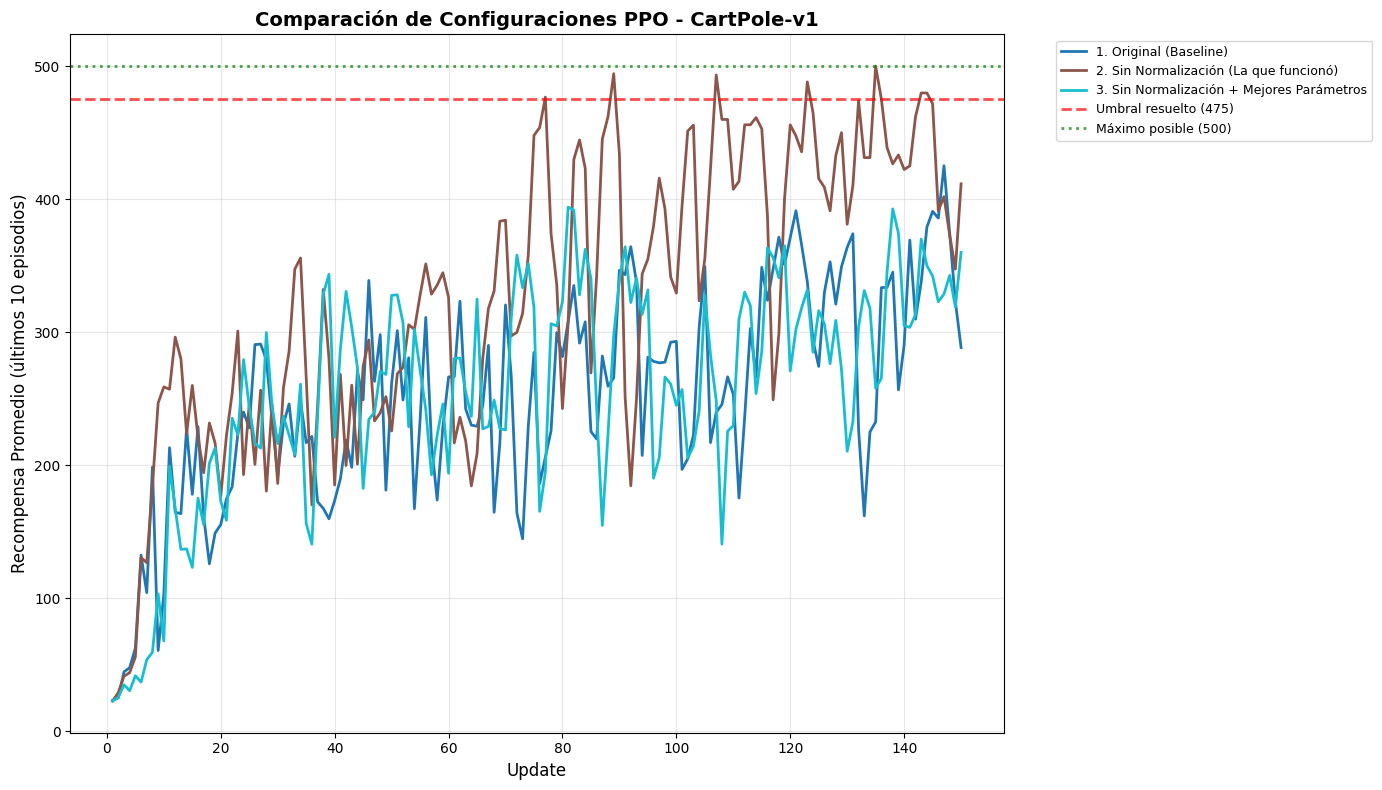

In [25]:
# Graficar todas las curvas juntas
plt.figure(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))

for i, result in enumerate(all_results):
    rewards = result['rewards_per_update']
    updates = range(1, len(rewards) + 1)
    plt.plot(updates, rewards, label=result['config_name'], linewidth=2, color=colors[i])

plt.axhline(475, color='r', linestyle='--', linewidth=2, label='Umbral resuelto (475)', alpha=0.7)
plt.axhline(500, color='g', linestyle=':', linewidth=2, label='Máximo posible (500)', alpha=0.7)

plt.xlabel('Update', fontsize=12)
plt.ylabel('Recompensa Promedio (últimos 10 episodios)', fontsize=12)
plt.title('Comparación de Configuraciones PPO - CartPole-v1', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Análisis de Entropía


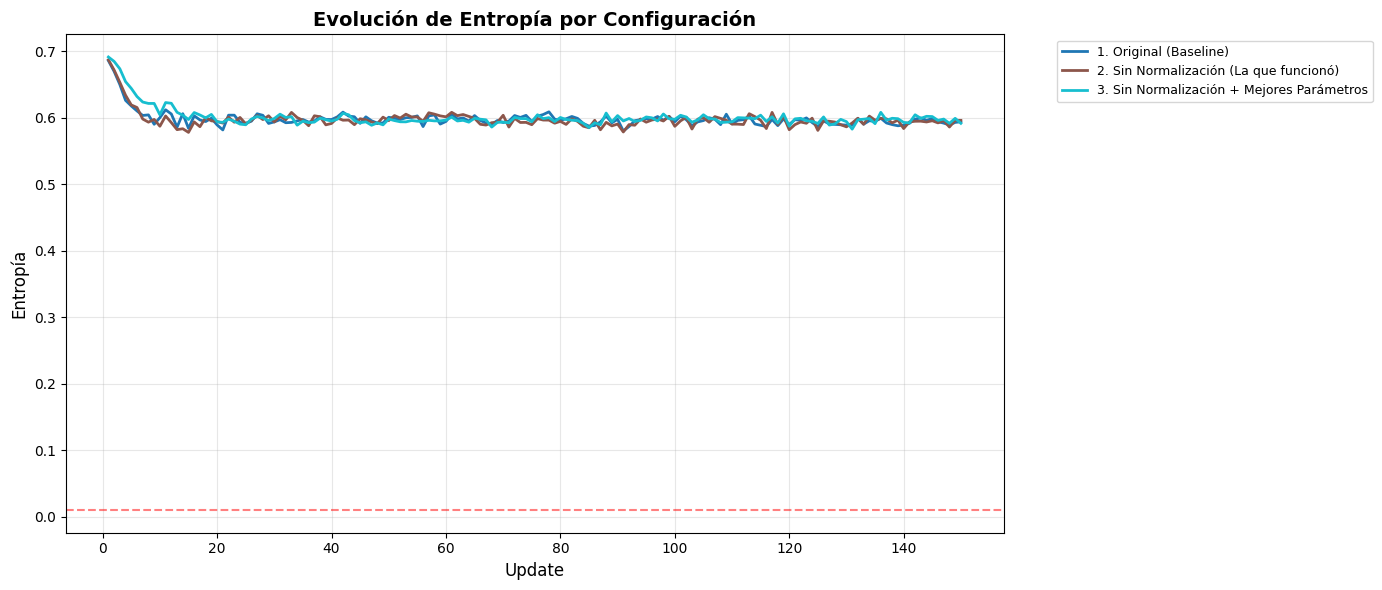

In [26]:
# Graficar evolución de entropía
plt.figure(figsize=(14, 6))

for i, result in enumerate(all_results):
    entropies = [-m['entropy_loss'] for m in result['metrics_history']]
    updates = range(1, len(entropies) + 1)
    plt.plot(updates, entropies, label=result['config_name'], linewidth=2, color=colors[i])

plt.xlabel('Update', fontsize=12)
plt.ylabel('Entropía', fontsize=12)
plt.title('Evolución de Entropía por Configuración', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.axhline(0.01, color='r', linestyle='--', alpha=0.5, label='Umbral bajo (0.01)')
plt.tight_layout()
plt.show()


## Resumen de Mejores Configuraciones


In [27]:
# Ordenar por mejor rendimiento
sorted_results = sorted(all_results, key=lambda x: x['final_avg_reward'], reverse=True)

print("\n" + "="*80)
print("RANKING DE CONFIGURACIONES (por Final Avg Reward)")
print("="*80)

for i, result in enumerate(sorted_results, 1):
    status = "✓ RESUELTO" if result['solved'] else "✗ No resuelto"
    print(f"\n{i}. {result['config_name']}")
    print(f"   Final Avg Reward: {result['final_avg_reward']:.2f}")
    print(f"   Max Reward: {max(result['episode_rewards']) if result['episode_rewards'] else 0:.2f}")
    print(f"   Status: {status}")
    print(f"   Timesteps: {result['total_timesteps']:,}")

print("\n" + "="*80)

# Mejor configuración
best = sorted_results[0]
print(f"\n🏆 MEJOR CONFIGURACIÓN: {best['config_name']}")
print(f"   Final Avg Reward: {best['final_avg_reward']:.2f}")
print(f"   Solved: {best['solved']}")



RANKING DE CONFIGURACIONES (por Final Avg Reward)

1. 2. Sin Normalización (La que funcionó)
   Final Avg Reward: 411.50
   Max Reward: 500.00
   Status: ✗ No resuelto
   Timesteps: 307,200

2. 3. Sin Normalización + Mejores Parámetros
   Final Avg Reward: 360.00
   Max Reward: 500.00
   Status: ✗ No resuelto
   Timesteps: 307,200

3. 1. Original (Baseline)
   Final Avg Reward: 288.50
   Max Reward: 500.00
   Status: ✗ No resuelto
   Timesteps: 307,200


🏆 MEJOR CONFIGURACIÓN: 2. Sin Normalización (La que funcionó)
   Final Avg Reward: 411.50
   Solved: False


---

# 🔬 Análisis de Hiperparámetros: Variaciones de "Sin Normalización"

Ahora vamos a probar diferentes hiperparámetros basados en la configuración que funcionó (Sin Normalización) para ver qué impacto tiene cada cambio.


In [28]:
# Configuraciones variadas basadas en "Sin Normalización" (la que funcionó)
# Base: learning_rate=3e-4, entropy_coef=0.01, n_epochs=10, use_normalization=False

hyperparam_configs = [
    {
        'name': 'Base: Sin Normalización',
        'learning_rate': 3e-4,
        'entropy_coef': 0.01,
        'n_epochs': 10,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 1: Mayor Entropía (0.1)',
        'learning_rate': 3e-4,
        'entropy_coef': 0.1,  # Aumentado de 0.01
        'n_epochs': 10,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 2: Menos Épocas (4)',
        'learning_rate': 3e-4,
        'entropy_coef': 0.01,
        'n_epochs': 4,  # Reducido de 10
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 3: LR Más Bajo (2.5e-4)',
        'learning_rate': 2.5e-4,  # Reducido de 3e-4
        'entropy_coef': 0.01,
        'n_epochs': 10,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 4: LR Más Bajo + Mayor Entropía',
        'learning_rate': 2.5e-4,
        'entropy_coef': 0.1,
        'n_epochs': 10,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 5: Menos Épocas + Mayor Entropía',
        'learning_rate': 3e-4,
        'entropy_coef': 0.1,
        'n_epochs': 4,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 6: LR Bajo + Menos Épocas + Mayor Entropía',
        'learning_rate': 2.5e-4,
        'entropy_coef': 0.1,
        'n_epochs': 4,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 64
    },
    {
        'name': 'Variación 7: Red Más Grande (128)',
        'learning_rate': 3e-4,
        'entropy_coef': 0.01,
        'n_epochs': 10,
        'use_normalization': False,
        'use_agent_api': False,
        'hidden_size': 128  # Aumentado de 64
    }
]

print(f"Total de variaciones a probar: {len(hyperparam_configs)}")
print(f"Updates por configuración: {TOTAL_UPDATES}")
print(f"Tiempo estimado: ~{len(hyperparam_configs) * TOTAL_UPDATES * 0.5 / 60:.1f} minutos")


Total de variaciones a probar: 8
Updates por configuración: 150
Tiempo estimado: ~10.0 minutos


## Ejecutar Pruebas de Hiperparámetros


In [29]:
# Ejecutar todas las variaciones
hyperparam_results = []

print(f"\n{'='*80}")
print(f"PRUEBA DE HIPERPARÁMETROS: {len(hyperparam_configs)} VARIACIONES")
print(f"Updates por configuración: {TOTAL_UPDATES}")
print(f"{'='*80}\n")

start_hyper = time.time()

for i, config in enumerate(hyperparam_configs, 1):
    print(f"\n{'#'*80}")
    print(f"[{i}/{len(hyperparam_configs)}] {config['name']}")
    print(f"{'#'*80}")
    
    result = train_cartpole_config(
        config_name=config['name'],
        learning_rate=config['learning_rate'],
        entropy_coef=config['entropy_coef'],
        n_epochs=config['n_epochs'],
        use_normalization=config['use_normalization'],
        use_agent_api=config['use_agent_api'],
        hidden_size=config['hidden_size'],
        total_updates=TOTAL_UPDATES,
        verbose=True
    )
    
    hyperparam_results.append(result)
    
    print(f"\n✓ Completado: {config['name']}")
    print(f"  Final Avg Reward: {result['final_avg_reward']:.2f}")
    print(f"  Max Reward: {max(result['episode_rewards']) if result['episode_rewards'] else 0:.2f}")
    print(f"  Solved: {'✓ SÍ' if result['solved'] else '✗ NO'}")
    print(f"  Time: {result['elapsed_time']:.1f}s")

elapsed_hyper = time.time() - start_hyper
print(f"\n{'='*80}")
print(f"TODAS LAS VARIACIONES COMPLETADAS")
print(f"Tiempo total: {elapsed_hyper/60:.1f} minutos")
print(f"{'='*80}")



PRUEBA DE HIPERPARÁMETROS: 8 VARIACIONES
Updates por configuración: 150


################################################################################
[1/8] Base: Sin Normalización
################################################################################

CONFIGURACIÓN: Base: Sin Normalización
Learning Rate: 0.0003
Entropy Coef: 0.01
N Epochs: 10
Normalization: False
Agent API: False
Hidden Size: 64

✓ Random seed set to 42
Update 005/150 | AvgR:   56.0 ± 32.18 | PolLoss: -0.0126 | Ent: 0.6194
Update 010/150 | AvgR:  258.9 ± 97.69 | PolLoss: -0.0050 | Ent: 0.5874
Update 015/150 | AvgR:  260.0 ± 118.56 | PolLoss: -0.0087 | Ent: 0.5782
Update 020/150 | AvgR:  176.9 ± 39.36 | PolLoss: -0.0010 | Ent: 0.5946
Update 025/150 | AvgR:  246.2 ± 105.04 | PolLoss: -0.0021 | Ent: 0.5910
Update 030/150 | AvgR:  186.4 ± 51.93 | PolLoss: -0.0087 | Ent: 0.5938
Update 035/150 | AvgR:  266.2 ± 110.45 | PolLoss: -0.0026 | Ent: 0.5963
Update 040/150 | AvgR:  185.2 ± 58.99 | PolLoss: -0.0039 | E

## Comparar Resultados de Hiperparámetros


In [30]:
# Tabla comparativa de hiperparámetros
hyperparam_data = []
for result in hyperparam_results:
    # Encontrar la configuración correspondiente
    config = next(c for c in hyperparam_configs if c['name'] == result['config_name'])
    hyperparam_data.append({
        'Configuración': result['config_name'],
        'LR': f"{config['learning_rate']:.2e}",
        'Entropy': config['entropy_coef'],
        'Epochs': config['n_epochs'],
        'Hidden': config['hidden_size'],
        'Final Avg Reward': f"{result['final_avg_reward']:.2f}",
        'Max Reward': f"{max(result['episode_rewards']) if result['episode_rewards'] else 0:.2f}",
        'Solved': '✓' if result['solved'] else '✗'
    })

df_hyper = pd.DataFrame(hyperparam_data)
print("\n" + "="*100)
print("COMPARACIÓN DE HIPERPARÁMETROS")
print("="*100)
print(df_hyper.to_string(index=False))
print("="*100)



COMPARACIÓN DE HIPERPARÁMETROS
                                       Configuración       LR  Entropy  Epochs  Hidden Final Avg Reward Max Reward Solved
                             Base: Sin Normalización 3.00e-04     0.01      10      64           411.50     500.00      ✗
                   Variación 1: Mayor Entropía (0.1) 3.00e-04     0.10      10      64           340.60     500.00      ✗
                       Variación 2: Menos Épocas (4) 3.00e-04     0.01       4      64           319.40     500.00      ✗
                   Variación 3: LR Más Bajo (2.5e-4) 2.50e-04     0.01      10      64           396.50     500.00      ✗
           Variación 4: LR Más Bajo + Mayor Entropía 2.50e-04     0.10      10      64           354.90     500.00      ✗
          Variación 5: Menos Épocas + Mayor Entropía 3.00e-04     0.10       4      64           397.30     500.00      ✗
Variación 6: LR Bajo + Menos Épocas + Mayor Entropía 2.50e-04     0.10       4      64           360.00     500.00

## Visualizar Curvas de Hiperparámetros


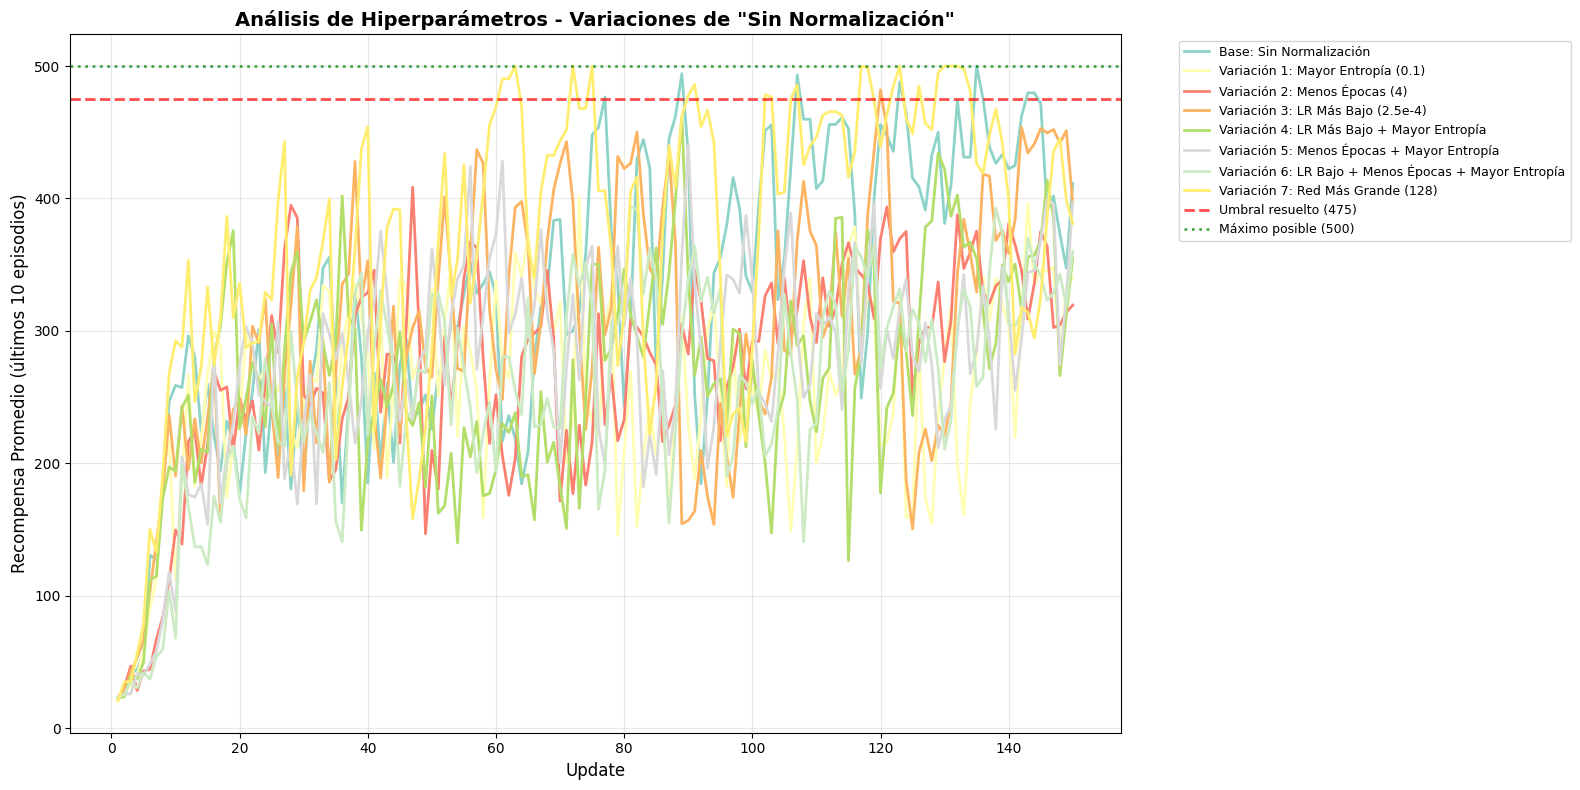

In [31]:
# Graficar todas las variaciones juntas
plt.figure(figsize=(16, 8))

colors_hyper = plt.cm.Set3(np.linspace(0, 1, len(hyperparam_results)))

for i, result in enumerate(hyperparam_results):
    rewards = result['rewards_per_update']
    updates = range(1, len(rewards) + 1)
    plt.plot(updates, rewards, label=result['config_name'], linewidth=2, color=colors_hyper[i])

plt.axhline(475, color='r', linestyle='--', linewidth=2, label='Umbral resuelto (475)', alpha=0.7)
plt.axhline(500, color='g', linestyle=':', linewidth=2, label='Máximo posible (500)', alpha=0.7)

plt.xlabel('Update', fontsize=12)
plt.ylabel('Recompensa Promedio (últimos 10 episodios)', fontsize=12)
plt.title('Análisis de Hiperparámetros - Variaciones de "Sin Normalización"', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Análisis de Impacto de Cada Hiperparámetro


In [ ]:
# Análisis del impacto de cada cambio
print("\n" + "="*80)
print("ANÁLISIS DE IMPACTO DE HIPERPARÁMETROS")
print("="*80)

base_result = next(r for r in hyperparam_results if 'Base:' in r['config_name'])
base_reward = base_result['final_avg_reward']

print(f"\n📊 Configuración Base: {base_result['final_avg_reward']:.2f}")

print("\n🔍 Impacto de cada cambio:")
print("-" * 80)

# Comparar cada variación con la base
for result in hyperparam_results:
    if 'Base:' not in result['config_name']:
        diff = result['final_avg_reward'] - base_reward
        change = "↑" if diff > 0 else "↓" if diff < 0 else "="
        print(f"{change} {result['config_name']:50s} | "
              f"Reward: {result['final_avg_reward']:6.2f} | "
              f"Diff: {diff:+7.2f}")

print("\n" + "="*80)

# Mejor variación
sorted_hyper = sorted(hyperparam_results, key=lambda x: x['final_avg_reward'], reverse=True)
best_hyper = sorted_hyper[0]
print(f"\n🏆 MEJOR VARIACIÓN: {best_hyper['config_name']}")
print(f"   Final Avg Reward: {best_hyper['final_avg_reward']:.2f}")
print(f"   Mejora sobre base: {best_hyper['final_avg_reward'] - base_reward:+.2f}")
print(f"   Solved: {best_hyper['solved']}")
